# Predição de velocidade média usando dados de radares da Vinte e Três de Maio
Para a realização das predições iremos usar dois algoritmos de Machine Learning do tipo ensemble de árvores de regressão. Os algoritmos em questão são:

- LightGBM
- Random Forests

## Importando dependências
Para instalar as dependências usando pip, execute o seguinte comando no terminal:

``` sh
    $ pip install -r requirements.txt
```

Caso você nunca teve contanto com pip e gosta de usar python, vale a pena dar uma olhada neste [link](https://www.w3schools.com/python/python_pip.asp).

In [1]:
# Biblioteca com a implementação do algoritmo LigthGBM (https://lightgbm.readthedocs.io/en/latest/)
import lightgbm as lgb

# Biblioteca com diversos algoritmos de machine learning e ferramentas que facilitam no treinamento e validação dos modelos (https://scikit-learn.org/stable/)
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Framework para encontrar hyperparâmetros ótimos (https://optuna.org/)
import optuna
from optuna.visualization.matplotlib import plot_param_importances, plot_slice

# Biblioteca para plottagem de gráfico (https://matplotlib.org/)
import matplotlib.pyplot as plt

# Biblioteca para lidar com matrizes como tabelas de forma eficiente (https://pandas.pydata.org/)
import pandas as pd

# Biblioteca para lidar com vetores/arrays em memória de forma eficiente (https://numpy.org/)
import numpy as np

# Bibliotecas padrões do python
import os                                   # Acesso a funções básicas dos sistema operacional (ler arquivos, listar arquivos de diretório, ...)
from typing import Tuple                    # Biblioteca para tipagem de parâmetros
from timeit import default_timer as timer   # Temporizador para medir performance
from datetime import timedelta

# Configurando o pandas
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", 6)

# Configurando o optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Importando o dataset
O dataset importado contém dados agregados de alguns radares da cidade de São Paulo, para intervalos de 4 em 4 minutos no mês de Março e Abril de 2018.

In [2]:
months = ["Marco", "Abril"]
data = []

for month in months:
    files = os.listdir(f"data/{month}")
    
    for file in files:
        data.append(pd.read_csv(f"data/{month}/{file}"))

data = pd.concat(data)
data

,Eixo,Num_Agrupado,Periodo,Est_Meteorol,Data,dia_sem,Vel_media,Vel_mediana,Vel_std,Vel_Reg,Ocup_media,Ocup_mediana,Ocup_std,Volume,Vol_eq
0,23deMaio_C,10433,P1,CGE,2018-03-01 00:00:00,3,142.907285,142.0,16.744492,167,645.397351,346.0,1126.028508,151.0,152.33
1,23deMaio_C,10433,P1,CGE,2018-03-01 00:04:00,3,140.327586,139.0,15.853799,167,526.563218,358.0,700.513663,174.0,172.66
2,23deMaio_C,10433,P1,CGE,2018-03-01 00:08:00,3,144.861111,144.0,19.526067,167,604.173611,279.0,1384.000901,144.0,143.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12237,Sumare_S,10652,P6,PI,2018-04-30 23:44:00,0,117.816667,119.0,9.764154,139,714.483333,683.5,168.367384,60.0,118.33
12238,Sumare_S,10652,P6,PI,2018-04-30 23:48:00,0,112.113636,112.5,11.942139,139,772.795455,703.0,311.148180,44.0,82.99
12239,Sumare_S,10652,P6,PI,2018-04-30 23:52:00,0,115.320755,114.0,9.462016,139,736.962264,726.0,109.572414,53.0,106.00


## Adicionando colunas com horário em minutos e o mês
Por exemplo, 01:30 da manhã é equivamente a 90 minutos após o início do dia.

In [3]:
def get_minutes(date):
    """Obtem o número de mínutos a partir do início de um dia usando uma data como string (`date`)"""
    time = date.split(" ")[-1].split(":")
    return int(time[0]) * 60 + int(time[1])

# Adiciona novas colunas
data["Minutos"] = data["Data"].map(lambda t: get_minutes(t))
data["Mes"] = data["Data"].map(lambda t: int(t.split("-")[1]))

# Mantem apenas colunas utilizadas
data = data[["Data", "Mes", "dia_sem", "Minutos", "Num_Agrupado", "Vel_media"]]

# Reseta os índices
data.index = pd.RangeIndex(len(data.index))

data

,Data,Mes,dia_sem,Minutos,Num_Agrupado,Vel_media
0,2018-03-01 00:00:00,3,3,0,10433,142.907285
1,2018-03-01 00:04:00,3,3,4,10433,140.327586
2,2018-03-01 00:08:00,3,3,8,10433,144.861111
...,...,...,...,...,...,...
557578,2018-04-30 23:44:00,4,0,1424,10652,117.816667
557579,2018-04-30 23:48:00,4,0,1428,10652,112.113636
557580,2018-04-30 23:52:00,4,0,1432,10652,115.320755


## Filtrando para conter apenas dados dos agrupamentos 10482, 10500 e 10433  (radar na Av. Vinte três de maio)

<AxesSubplot:title={'center':'Velocidade média medidas no radar alvo'}, ylabel='Velocidade média [dm/s]'>

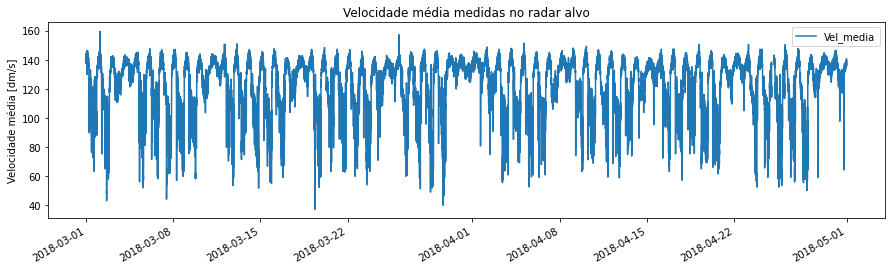

In [4]:
# Numero de agrupamentos a jusante e a montante do radar alvo
downstream =  10500
target = 10482
upstream = 10433

def get_sensor_data(data, sensor_group):
    """Seleciona apenas os dados sensores identificados por `sensor_group` e adiciona índice da DataFrames como data de medição, removendo possíveis duplicatas."""
    sensor_data = data[data["Num_Agrupado"] == sensor_group]
    sensor_data.index = pd.to_datetime(sensor_data["Data"]).values
    sensor_data = sensor_data.drop(["Data"], axis=1)
    sensor_data = sensor_data[~sensor_data.index.duplicated()]
    sensor_data.sort_index(inplace=True)
    return sensor_data

# Dados a jusante, a montante e do radar alvo
down_data = get_sensor_data(data, downstream)
up_data = get_sensor_data(data, upstream)
target_data = get_sensor_data(data, target)

target_data.plot(y="Vel_media", ylabel="Velocidade média [dm/s]", title="Velocidade média medidas no radar alvo", figsize=(15, 4))
# target_data

# Exemplo de tabela para treinamento do modelo
Os dados utilizados para o treinamento do modelo poderão ser organizados de forma paramétrica modificando os seguintes argumentos da função `get_clean_data`:
- `step_back`: caso `steps_back` seja igual 3, cada linha da nova tabela terá, além da velocidade no instantante atual, a velocidade média a 3 passos atrás (12 minutos).
- `steps_forward`: caso `steps_forward` seja igual 3, cada linha da nova tabela terá, além da velocidade média no instantante atual, a velocidade média daqui a 3 passos (12 minutos).
- `steps_back_spacing`: caso `steps_back_spacing` seja igual a 1, cada linha da nova tabela terá a velocidade média de 1 em 1 passo (4 minutos) no passado até chegar no valor definido por `steps_back`. 
- `steps_forward_spacing`: caso `steps_forward_spacing` seja igual a 1, cada linha da nova tabela terá a velocidade média de 1 em 1 passo (4 minutos) no futuro até chegar no valor definido por `steps_forward`.
- `add_downstream_data`: define se dados do radar a justante devem ser utilizados (colunas `V_j_t*`).
- `add_upstream_data`: define se dados do radar a montante devem ser utilizados (colunas `V_m_t*`).

In [5]:
config = {
    "steps_back": 3,
    "steps_forward": 15,

    "steps_back_spacing": 1,
    "steps_forward_spacing": 5,

    "add_downstream_data": True,
    "add_upstream_data": True
}

def get_clean_data(target_data, down_data, up_data, steps_back=15, steps_forward=15, steps_back_spacing=1, steps_forward_spacing=1, add_downstream_data=True, add_upstream_data=True):
    # Nova tabela com dados formatados corretamente
    clean_data = pd.DataFrame()

    # Adiciona colunas de `minutos_dia`, `dia_sem` e `mes` para nova tabela
    clean_data["minutos_dia"] = pd.to_numeric(target_data["Minutos"], downcast="integer")
    clean_data["dia_sem"] = pd.Categorical(pd.to_numeric(target_data["dia_sem"], downcast="integer"))
    clean_data["mes"] = pd.Categorical(pd.to_numeric(target_data["Mes"], downcast="integer"))


    # Criando colunas para velocidades passadas para os radares alvo, a montante e a jusante
    for step in range(steps_back, 0, -steps_back_spacing):
        clean_data[f"V_t-{step}"] = target_data["Vel_media"].shift(step)
        if add_downstream_data:
            clean_data[f"V_j_t-{step}"] = down_data["Vel_media"].shift(step)
        if add_upstream_data:
            clean_data[f"V_m_t-{step}"] = up_data["Vel_media"].shift(step)


    # Criando colunas para velocidades atuais para os radares alvo, a montante e a jusante
    clean_data["V_t"] = target_data["Vel_media"]
    if add_downstream_data:
        clean_data[f"V_j_t"] = down_data["Vel_media"]
    if add_upstream_data:
        clean_data[f"V_m_t"] = up_data["Vel_media"]


    # Criando colunas para variáveis dependentes (velocidades futuras)
    for step in range(steps_forward_spacing, steps_forward+1, steps_forward_spacing):
        if add_downstream_data:
            clean_data[f"V_j_t+{step}"] = down_data["Vel_media"].shift(-step)
        if add_upstream_data:
            clean_data[f"V_m_t+{step}"] = up_data["Vel_media"].shift(-step)
        clean_data[f"V_t+{step}"] = target_data["Vel_media"].shift(-step)

    if add_downstream_data:
        clean_data[f"V_j_t+{steps_forward}"] = down_data["Vel_media"].shift(-steps_forward)
    if add_upstream_data:
        clean_data[f"V_m_t+{steps_forward}"] = up_data["Vel_media"].shift(-steps_forward)
    clean_data[f"V_t+{steps_forward}"] = target_data["Vel_media"].shift(-steps_forward)


    # Remove linhas faltantes por conta do deslocamento das velocidades futuras e passadas
    clean_data = clean_data.iloc[steps_back:-steps_forward]

    # Preenche os campos vazios com dados do passado
    clean_data.ffill(inplace=True)

    return clean_data

clean_data = get_clean_data(target_data, down_data, up_data, **config)
clean_data

,minutos_dia,dia_sem,mes,V_t-3,V_j_t-3,V_m_t-3,V_t-2,V_j_t-2,V_m_t-2,V_t-1,...,V_m_t,V_j_t+5,V_m_t+5,V_t+5,V_j_t+10,V_m_t+10,V_t+10,V_j_t+15,V_m_t+15,V_t+15
2018-03-01 00:08:00,8,3,3,140.095808,169.833333,139.650000,138.126126,173.000000,142.907285,140.952756,...,144.861111,136.105263,143.288591,138.206612,142.560976,145.520408,142.494505,145.108108,142.008850,139.041667
2018-03-01 00:12:00,12,3,3,138.126126,173.000000,142.907285,140.952756,136.578947,140.327586,138.549133,...,141.150602,141.377358,138.404580,140.030075,142.682927,146.202020,140.495238,142.088235,141.720000,140.439252
2018-03-01 00:16:00,16,3,3,140.952756,136.578947,140.327586,138.549133,136.895833,144.861111,142.333333,...,143.918919,141.302326,142.340741,140.666667,151.977273,139.862745,139.697248,140.900000,141.519231,141.276190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-30 22:44:00,1364,0,4,135.383673,141.554054,134.908772,138.930769,139.037594,136.444000,136.316206,...,136.643123,145.135802,134.973180,138.917647,144.707547,137.021661,137.959459,143.292135,135.820513,140.695122
2018-04-30 22:48:00,1368,0,4,138.930769,139.037594,136.444000,136.316206,144.917293,131.881757,138.056000,...,133.741935,141.593750,136.830258,137.513889,140.205607,138.655814,136.363229,145.304762,137.568306,139.983333
2018-04-30 22:52:00,1372,0,4,136.316206,144.917293,131.881757,138.056000,138.978102,136.643123,137.964706,...,135.683794,143.023810,136.656250,136.163522,141.906542,135.689498,135.807229,141.228261,137.810680,139.148148


# Separando dados para treino e teste
Para a realização do teste faremos validação cruzada para séries temporais.

Além disso, para treinar o modelo é necessário dividir as variáveis de entrada e saída.

No nosso caso, a variável de entrada (input) do modelo será um vetor contendo as seguintes informações:

$ X = [minutos\_dia, dia\_dia, vel_{t-n}, ..., vel_{t-1}, vel_{t}] $

A variável de saída (output) do modelo será um vetor contendo as seguintes informações:

$ Y = [vel_{t+1}, ..., vel_{t+(n-1)}, vel_{t+n}] $

Sendo que $n$ é o número de passos para frente e para trás que serão utilizados para treinar o modelo.
Desta forma, nosso modelo poderá prever velocidades até $4*n$ minutos no futuro, já que o passo é de 4 minutos.

In [6]:
test_splits = [
    ("2018-03-18", "2018-03-25"),
    ("2018-03-25", "2018-04-01"),
    ("2018-04-01", "2018-04-08"),
    ("2018-04-08", "2018-04-15"),
    ("2018-04-15", "2018-04-22"),
    ("2018-04-22", "2018-05-01"),
]


def timeseries_train_test_split(data, test_start, test_end):
    train_data = data[data.index < test_start] 
    test_data = data[(data.index > test_start) & (data.index < test_end)]

    # Selecionando apenas as colunas com as variáveis dependentes (X)
    X_train = train_data.filter(regex=r"^(?!.*V_.*\+.*|data).*")
    X_test = test_data.filter(regex=r"^(?!.*V_.*\+.*|data).*")

    # Selecionando apenas as colunas com as velocidades futuras (Y)
    y_train = train_data.filter(regex=r".*V_.*\+.*")
    y_test = test_data.filter(regex=r".*V_.*\+.*")

    return X_train, X_test, y_train, y_test

### Exemplo de separação de dados
Abaixo está um exemplo de separação de $X$ e $Y$ para treino e teste dos modelos. Para o seguinte exemplo, temos:
- Dados de treino: `2018-03-01` até  `2018-03-24`
- Dados de teste: `2018-03-25` até `2018-04-01` (última semana de Março de 2018)

In [7]:
test_start, test_end = test_splits[0]
X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

In [8]:
X_train

,minutos_dia,dia_sem,mes,V_t-3,V_j_t-3,V_m_t-3,V_t-2,V_j_t-2,V_m_t-2,V_t-1,V_j_t-1,V_m_t-1,V_t,V_j_t,V_m_t
2018-03-01 00:08:00,8,3,3,140.095808,169.833333,139.650000,138.126126,173.000000,142.907285,140.952756,136.578947,140.327586,138.549133,136.895833,144.861111
2018-03-01 00:12:00,12,3,3,138.126126,173.000000,142.907285,140.952756,136.578947,140.327586,138.549133,136.895833,144.861111,142.333333,140.525424,141.150602
2018-03-01 00:16:00,16,3,3,140.952756,136.578947,140.327586,138.549133,136.895833,144.861111,142.333333,140.525424,141.150602,143.431655,139.879310,143.918919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-17 23:48:00,1428,5,3,134.313589,139.633028,133.675926,132.338235,140.009709,135.063433,136.128405,138.623077,134.082759,133.570342,140.233083,132.786942
2018-03-17 23:52:00,1432,5,3,132.338235,140.009709,135.063433,136.128405,138.623077,134.082759,133.570342,140.233083,132.786942,132.206767,140.389381,133.456376
2018-03-17 23:56:00,1436,5,3,136.128405,138.623077,134.082759,133.570342,140.233083,132.786942,132.206767,140.389381,133.456376,136.056769,140.238532,136.611321


In [9]:
X_test

,minutos_dia,dia_sem,mes,V_t-3,V_j_t-3,V_m_t-3,V_t-2,V_j_t-2,V_m_t-2,V_t-1,V_j_t-1,V_m_t-1,V_t,V_j_t,V_m_t
2018-03-18 00:04:00,4,6,3,132.206767,140.389381,133.456376,136.056769,140.238532,136.611321,136.738916,142.010526,138.572165,136.983539,140.019608,134.585859
2018-03-18 00:08:00,8,6,3,136.056769,140.238532,136.611321,136.738916,142.010526,138.572165,136.983539,140.019608,134.585859,135.882353,141.054945,137.362069
2018-03-18 00:12:00,12,6,3,136.738916,142.010526,138.572165,136.983539,140.019608,134.585859,135.882353,141.054945,137.362069,135.028807,142.322034,135.750943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-24 23:48:00,1428,5,3,132.902280,136.240741,131.140884,135.138614,137.245033,134.207237,133.713805,137.331250,133.965636,131.885522,137.874286,132.315287
2018-03-24 23:52:00,1432,5,3,135.138614,137.245033,134.207237,133.713805,137.331250,133.965636,131.885522,137.874286,132.315287,132.164557,138.401786,135.185185
2018-03-24 23:56:00,1436,5,3,133.713805,137.331250,133.965636,131.885522,137.874286,132.315287,132.164557,138.401786,135.185185,132.339041,142.394737,132.925926


In [10]:
y_train

,V_j_t+5,V_m_t+5,V_t+5,V_j_t+10,V_m_t+10,V_t+10,V_j_t+15,V_m_t+15,V_t+15
2018-03-01 00:08:00,136.105263,143.288591,138.206612,142.560976,145.520408,142.494505,145.108108,142.008850,139.041667
2018-03-01 00:12:00,141.377358,138.404580,140.030075,142.682927,146.202020,140.495238,142.088235,141.720000,140.439252
2018-03-01 00:16:00,141.302326,142.340741,140.666667,151.977273,139.862745,139.697248,140.900000,141.519231,141.276190
...,...,...,...,...,...,...,...,...,...
2018-03-17 23:48:00,141.054945,137.362069,135.882353,142.564815,136.608333,139.298701,144.333333,138.205742,137.745098
2018-03-17 23:52:00,142.322034,135.750943,135.028807,144.477612,140.660633,137.063636,140.815789,136.587156,136.961538
2018-03-17 23:56:00,142.610526,134.903101,136.052632,141.827957,139.121951,136.135000,138.112500,135.169154,139.324022


In [11]:
y_test

,V_j_t+5,V_m_t+5,V_t+5,V_j_t+10,V_m_t+10,V_t+10,V_j_t+15,V_m_t+15,V_t+15
2018-03-18 00:04:00,143.672897,135.875536,134.557312,145.078125,137.514151,139.954545,141.519481,136.569231,138.728324
2018-03-18 00:08:00,142.564815,136.608333,139.298701,144.333333,138.205742,137.745098,140.477612,140.010695,136.639752
2018-03-18 00:12:00,144.477612,140.660633,137.063636,140.815789,136.587156,136.961538,143.133333,133.911765,135.467391
...,...,...,...,...,...,...,...,...,...
2018-03-24 23:48:00,144.986301,133.683077,132.344615,137.678571,134.673139,133.094077,134.197674,134.471831,133.418440
2018-03-24 23:52:00,139.884615,134.760000,135.872852,138.070513,133.813559,132.302632,137.041420,136.864111,132.691176
2018-03-24 23:56:00,138.232704,135.182099,134.702899,138.236220,136.207792,134.510274,136.496894,135.702265,129.469178


### Visualizando a validação cruzada adotada

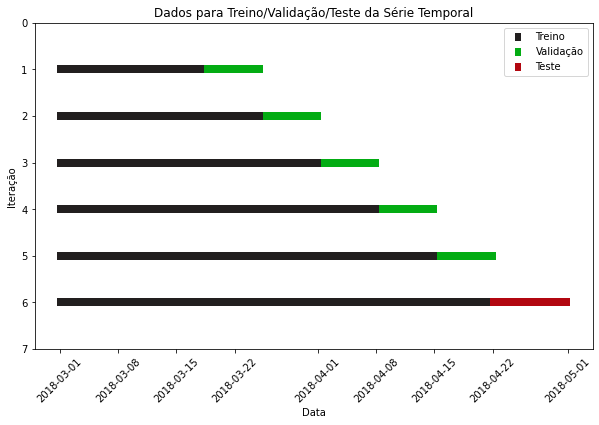

In [12]:
fig, ax = plt.subplots(figsize=(10, len(test_splits)))

for i, (test_start, test_end) in enumerate(test_splits):
    X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)        
    p2 = ax.scatter(X_test.index, [1 + i] * len(X_test.index) ,c="#03AC13", marker="_", lw=8)
    p1 = ax.scatter(X_train.index, [1 + i] * len(X_train.index)  ,c="#221f1f", marker="_", lw=8)
    if i != len(test_splits) - 1:        
        p3 = ax.scatter([], [] ,c="#b20710", marker="_", lw=8)
    else:
        p3 = ax.scatter(X_test.index, [1 + i] * len(X_test.index) ,c="#b20710", marker="_", lw=8)

    ax.legend([p1, p2, p3], ["Treino", "Validação", "Teste"])


ax.set(
    title="Dados para Treino/Validação/Teste da Série Temporal",
    xlabel="Data",
    ylabel="Iteração",
    ylim=[len(test_splits)+1, 0],        
)

plt.xticks(rotation=45)
plt.show()

### Otimizando hiperparâmetros para o algoritmo LigthGBM com estratégia direta
A estratégia direta é bem simples. Nela iremos considerar como variável independente apenas a velocidade 15 passos (1 hora) no futuro:

$ Y = vel_{t+15} $

In [13]:
def lgb_direct_objective(trial, target_data, down_data, up_data, test_splits, results):
    # Parâmetros para configurar o formato dos dados para alimentar o modelo
    data_params = {
        "steps_back": trial.suggest_int("steps_back", 5, 15, step=5),
        "steps_forward": 15,

        "steps_back_spacing": trial.suggest_int("steps_back_spacing", 1, 5, step=2),
        "steps_forward_spacing": 15,

        "add_downstream_data": True,
        "add_upstream_data": True
    }

    # Parâmetros para configurar o modelo
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=20),
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 800, step=50),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 50, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 50, step=5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0, step=0.1),
    }

    clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

    # Lista de acuracias
    mse = np.zeros(len(test_splits))
    mae = np.zeros(len(test_splits))
    mape = np.zeros(len(test_splits))

    train_time = 0
    pred_time = 0

    # Iterações da validação cruzada
    for i, (test_start, test_end) in enumerate(test_splits): 
        # Separa dados de treino e teste      
        X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

        # Modelo LigthGBM com estratégia direta
        lgb_model_direct = lgb.LGBMRegressor(**model_params)

        # Treina o modelo
        start = timer()
        lgb_model_direct.fit(X_train, y_train.iloc[:,-1])
        end = timer()
        train_time += end - start

        # Realiza a predição
        start = timer()
        pred = lgb_model_direct.predict(X_test)
        end = timer()
        pred_time += end - start

        # Calcula acuracias para a iteção atual
        mse[i] = mean_squared_error(y_test.iloc[:,-1], pred)
        mae[i] = mean_absolute_error(y_test.iloc[:,-1], pred)
        mape[i] = mean_absolute_percentage_error(y_test.iloc[:,-1], pred)

    result_row = {
        **data_params,
        **model_params, 
        "train_time [s]": train_time,
        "prediction_time [s]": pred_time,
        "MAPE": mape.mean(),
        "MAE": mae.mean(),
        "MSE": mse.mean()
        }
    results.append(result_row)

    # O modelo é levemente punido caso leve grande tempo para treinar e fazer predições
    score = result_row["MSE"]
    return score

lgb_direct_results = []
lgb_direct_study = optuna.create_study(direction="minimize", study_name="LightGBM direto")
lgb_direct_obj = lambda trial: lgb_direct_objective(trial, target_data, down_data, up_data, test_splits[:-1], lgb_direct_results)
lgb_direct_study.optimize(lgb_direct_obj, n_trials=200)
lgb_direct_results = pd.DataFrame(lgb_direct_results)

KeyboardInterrupt: 

Melhor conjunto de parâmetros:
	steps_back: 5
	steps_back_spacing: 3
	max_depth: 10
	num_leaves: 900
	min_child_samples: 100
	n_estimators: 400
	learning_rate: 0.01
	reg_alpha: 45
	reg_lambda: 30
	colsample_bytree: 1.0
MSE: 97.39531939812727


C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/19322597.py:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(lgb_direct_study)
C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/19322597.py:9: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(lgb_direct_study)


array([<AxesSubplot:xlabel='colsample_bytree', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='max_depth'>,
       <AxesSubplot:xlabel='min_child_samples'>,
       <AxesSubplot:xlabel='n_estimators'>,
       <AxesSubplot:xlabel='num_leaves'>,
       <AxesSubplot:xlabel='reg_alpha'>,
       <AxesSubplot:xlabel='reg_lambda'>,
       <AxesSubplot:xlabel='steps_back'>,
       <AxesSubplot:xlabel='steps_back_spacing'>], dtype=object)

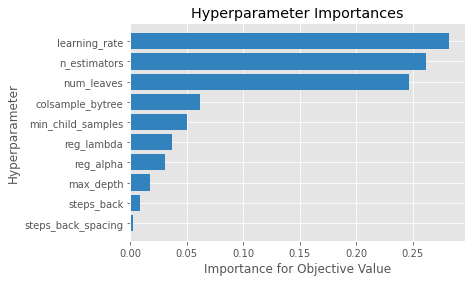

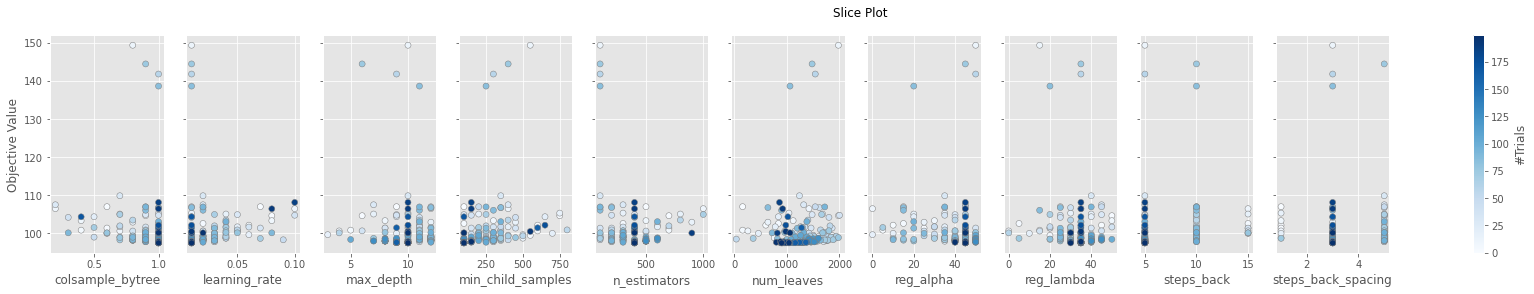

In [ ]:
print("Melhor conjunto de parâmetros:")
for key, value in lgb_direct_study.best_params.items():
    print(f"\t{key}: {value}")

print(f"MSE: {lgb_direct_study.best_value}")

lgb_direct_results.to_csv("hyperparameters/lgb_direct.csv", index=False)
plot_param_importances(lgb_direct_study)
plot_slice(lgb_direct_study)

## LightGBM direto: avaliando modelo ótimo na base de testes

In [22]:
results = []
test_start, test_end = test_splits[-1]
# test_start, test_end = ("2018-04-23", "2018-04-28")
# test_start, test_end = ("2018-04-28", "2018-04-30")

# Parâmetros para configurar o formato dos dados para alimentar o modelo
data_params = {
    "steps_back": 5,
    "steps_forward": 15,

    "steps_back_spacing": 3,
    "steps_forward_spacing": 15,

    "add_downstream_data": True,
    "add_upstream_data": True
}

# Parâmetros para configurar o modelo
model_params = {
    "max_depth": 10,
    "num_leaves": 900,
    "min_child_samples": 100,
    "n_estimators": 400,
    "learning_rate": 0.01,
    "reg_alpha": 45,
    "reg_lambda": 30,
    "colsample_bytree": 1.0
}

clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

# Separa dados de treino e teste      
X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

# Modelo LigthGBM com estratégia direta
lgb_model_direct = lgb.LGBMRegressor(**model_params)

# Treina o modelo
start = timer()
lgb_model_direct.fit(X_train, y_train.iloc[:,-1])
end = timer()
train_time = end - start

# Realiza a predição
start = timer()
pred_lgb_direct = lgb_model_direct.predict(X_test)
end = timer()
pred_time = end - start

# Calcula acuracias para a iteção atual
mse = mean_squared_error(y_test.iloc[:,-1], pred_lgb_direct)
mae = mean_absolute_error(y_test.iloc[:,-1], pred_lgb_direct)
mape = mean_absolute_percentage_error(y_test.iloc[:,-1], pred_lgb_direct)

result_row = {
    "modelo": "LightGBM direto",
    "train_time [s]": train_time,
    "prediction_time [s]": pred_time,
    "MAPE": mape,
    "MAE": mae,
    "MSE": mse
    }
results.append(result_row)

### Otimizando hiperparâmetros para o algoritmo LightGBM com estratégia iterativa
Como o algoritmo LightGBM não possui suporte para mais de uma variável de saída, foi necessário utilizar uma estratégia para contornar o problema e gerar um modelo com múltiplas variáveis de saída. A estratégia em questão é a estratégia iterativa que consiste em criar $n$ modelos para cada uma das $n$ variáveis independentes da seguinte forma:

$ Y = [vel_{t+1}, ..., vel_{t+(n-1)}, vel_{t+n}] $

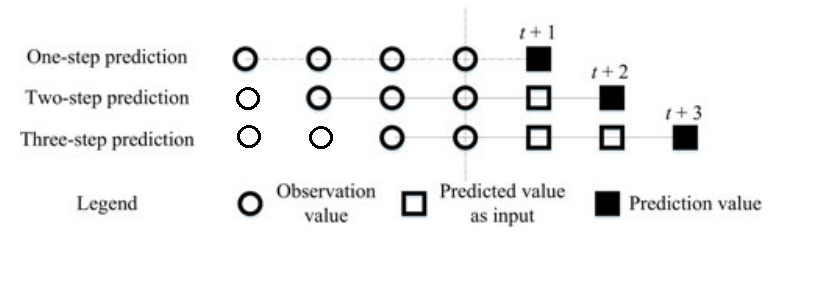

In [ ]:
def lgb_iterated_objective(trial, target_data, down_data, up_data, test_splits, results):
    # Parâmetros para configurar o formato dos dados para alimentar o modelo
    data_params = {
        "steps_back": trial.suggest_int("steps_back", 5, 15, step=5),
        "steps_forward": 15,

        "steps_back_spacing": trial.suggest_int("steps_back_spacing", 1, 5, step=2),
        "steps_forward_spacing": trial.suggest_int("steps_forward_spacing", 1, 5, step=2),

        "add_downstream_data": True,
        "add_upstream_data": True
    }

    # Parâmetros para configurar o modelo
    model_params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=20),
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 800, step=50),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 50, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 50, step=5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0, step=0.1)
    }

    clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

    # Lista de acuracias
    mse = np.zeros(len(test_splits))
    mae = np.zeros(len(test_splits))
    mape = np.zeros(len(test_splits))

    train_time = 0
    pred_time = 0

    # Iterações da validação cruzada
    for i, (test_start, test_end) in enumerate(test_splits): 
        # Separa dados de treino e teste      
        X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

        # Modelo LGBM com estratégia iterativa (scikitlearn - RegressorChain)
        lgb_model_iterated = RegressorChain(lgb.LGBMRegressor(**model_params))

        # Treina o modelo
        start = timer()
        lgb_model_iterated.fit(X_train, y_train.values)
        end = timer()
        train_time += end - start

        # Realiza a predição
        start = timer()
        pred = lgb_model_iterated.predict(X_test)[:,-1]
        end = timer()
        pred_time += end - start

        # Calcula acuracias para a iteção atual
        mse[i] = mean_squared_error(y_test.iloc[:,-1], pred)
        mae[i] = mean_absolute_error(y_test.iloc[:,-1], pred)
        mape[i] = mean_absolute_percentage_error(y_test.iloc[:,-1], pred)

    result_row = {
        **data_params,
        **model_params,
        "train_time [s]": train_time,
        "prediction_time [s]": pred_time,
        "MAPE": mape.mean(),
        "MAE": mae.mean(),
        "MSE": mse.mean()
        }
    results.append(result_row)

    # O modelo é levemente punido caso leve grande tempo para treinar e fazer predições
    score = result_row["MSE"]
    return score

lgb_iterated_results = []
lgb_iterated_study = optuna.create_study(direction="minimize", study_name="LightGBM iterador")
lgb_iterated_obj = lambda trial: lgb_iterated_objective(trial, target_data, down_data, up_data, test_splits[:-1], lgb_iterated_results)
lgb_iterated_study.optimize(lgb_iterated_obj, n_trials=200)
lgb_iterated_results = pd.DataFrame(lgb_iterated_results)

KeyboardInterrupt: 

Melhor conjunto de parâmetros:
	steps_back: 10
	steps_back_spacing: 3
	steps_forward_spacing: 5
	max_depth: 12
	num_leaves: 320
	min_child_samples: 150
	n_estimators: 500
	learning_rate: 0.02
	reg_alpha: 15
	reg_lambda: 50
	colsample_bytree: 0.4
Score: 101.52466616997471


C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/2600708945.py:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(lgb_iterated_study)
C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/2600708945.py:9: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(lgb_iterated_study)


array([<AxesSubplot:xlabel='colsample_bytree', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='max_depth'>,
       <AxesSubplot:xlabel='min_child_samples'>,
       <AxesSubplot:xlabel='n_estimators'>,
       <AxesSubplot:xlabel='num_leaves'>,
       <AxesSubplot:xlabel='reg_alpha'>,
       <AxesSubplot:xlabel='reg_lambda'>,
       <AxesSubplot:xlabel='steps_back'>,
       <AxesSubplot:xlabel='steps_back_spacing'>,
       <AxesSubplot:xlabel='steps_forward_spacing'>], dtype=object)

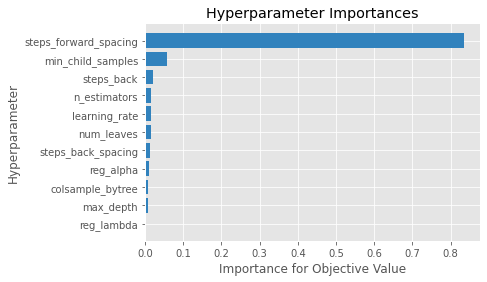

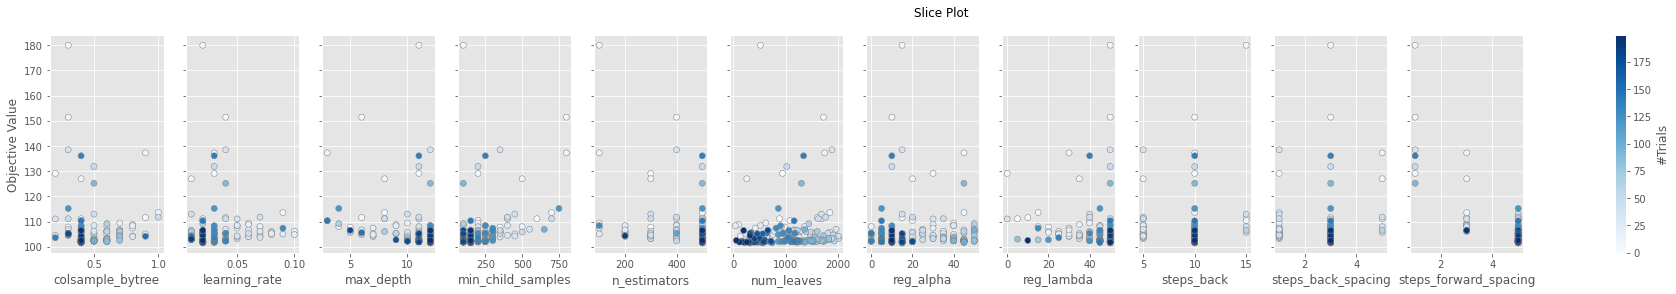

In [ ]:
print("Melhor conjunto de parâmetros:")
for key, value in lgb_iterated_study.best_params.items():
    print(f"\t{key}: {value}")

print(f"Score: {lgb_iterated_study.best_value}")

lgb_iterated_results.to_csv("hyperparameters/lgb_iterated.csv", index=False)
plot_param_importances(lgb_iterated_study)
plot_slice(lgb_iterated_study)

## LightGBM iterado: Avaliando o modelo ótimo na base de teste

In [15]:
# Parâmetros para configurar o formato dos dados para alimentar o modelo
data_params = {
    "steps_back": 10,
    "steps_forward": 15,

    "steps_back_spacing": 3,
    "steps_forward_spacing": 5,

    "add_downstream_data": True,
    "add_upstream_data": True
}

# Parâmetros para configurar o modelo
model_params = {
    "max_depth": 12,
    "num_leaves": 320,
    "min_child_samples": 150,
    "n_estimators": 500,
    "learning_rate": 0.02,
    "reg_alpha": 15,
    "reg_lambda": 50,
    "colsample_bytree": 0.4
}

clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

# Separa dados de treino e teste      
X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

# Modelo LGBM com estratégia iterativa (scikitlearn - RegressorChain)
lgb_model_iterated = RegressorChain(lgb.LGBMRegressor(**model_params))

# Treina o modelo
start = timer()
lgb_model_iterated.fit(X_train, y_train.values)
end = timer()
train_time = end - start

# Realiza a predição
start = timer()
pred_lgb_iterated = lgb_model_iterated.predict(X_test)[:,-1]
end = timer()
pred_time = end - start

# Calcula acuracias para a iteção atual
mse = mean_squared_error(y_test.iloc[:,-1], pred_lgb_iterated)
mae = mean_absolute_error(y_test.iloc[:,-1], pred_lgb_iterated)
mape = mean_absolute_percentage_error(y_test.iloc[:,-1], pred_lgb_iterated)

result_row = {
    "modelo": "LightGBM iterado",
    "train_time [s]": train_time,
    "prediction_time [s]": pred_time,
    "MAPE": mape,
    "MAE": mae,
    "MSE": mse
    }
results.append(result_row)

### Otimizando hiperparâmetros para o algoritmo Random Forests
Como a implementação do Random Forests do scikit learn já possui suporte para diversas variáveis de saída, já foi possível utilizar diretamente as seguintes variáveis independentes:

$ Y = [vel_{t+1}, ..., vel_{t+(n-1)}, vel_{t+n}] $

In [ ]:
def rf_objective(trial, target_data, down_data, up_data, test_splits, results):
    # Parâmetros para configurar o formato dos dados para alimentar o modelo
    data_params = {
        "steps_back": 5,
        "steps_forward": 15,

        "steps_back_spacing": 1,
        "steps_forward_spacing": 1,

        "add_downstream_data": True,
        "add_upstream_data": True
    }

    # Parâmetros para configurar o modelo
    model_params = {
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "max_depth": trial.suggest_int("max_depth", 10, 110, step=10),
        "min_samples_split": trial.suggest_categorical("min_samples_split", [2, 5, 10, 20]),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf", [1, 2, 4, 8])
    }

    clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

    # Lista de acuracias
    mse = np.zeros(len(test_splits))
    mae = np.zeros(len(test_splits))
    mape = np.zeros(len(test_splits))

    train_time = 0
    pred_time = 0

    # Iterações da validação cruzada
    for i, (test_start, test_end) in enumerate(test_splits): 
        # Separa dados de treino e teste      
        X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

        # Modelo Random Forests (suporta nativamente multiplas variáveis de saída)
        rf_model = RandomForestRegressor()

        # Treina o modelo
        start = timer()
        rf_model.fit(X_train, y_train)
        end = timer()
        train_time += end - start

        # Realiza a predição
        start = timer()
        pred = rf_model.predict(X_test)[:,-1]
        end = timer()
        pred_time += end - start

        # Calcula acuracias para a iteção atual
        mse[i] = mean_squared_error(y_test.iloc[:,-1], pred)
        mae[i] = mean_absolute_error(y_test.iloc[:,-1], pred)
        mape[i] = mean_absolute_percentage_error(y_test.iloc[:,-1], pred)

    result_row = {
        **data_params,
        **model_params,
        "train_time [s]": train_time,
        "prediction_time [s]": pred_time,
        "MAPE": mape.mean(),
        "MAE": mae.mean(),
        "MSE": mse.mean()
        }
    results.append(result_row)

    # O modelo é levemente punido caso leve grande tempo para treinar e fazer predições
    score = result_row["MSE"]
    return score

rf_results = []
rf_study = optuna.create_study(direction="minimize", study_name="Random Forests")
rf_obj = lambda trial: rf_objective(trial, target_data, down_data, up_data, test_splits[:-1], rf_results)
rf_study.optimize(rf_obj, n_trials=100)
rf_results = pd.DataFrame(rf_results)

Melhor conjunto de parâmetros:
	n_estimators: 200
	max_features: sqrt
	max_depth: 110
	min_samples_split: 2
	min_samples_leaf: 4
Score: 104.03532728158773


C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/3690615504.py:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(rf_study)
C:\Users\Murilo\AppData\Local\Temp/ipykernel_13624/3690615504.py:9: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(rf_study)


array([<AxesSubplot:xlabel='max_depth', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='max_features'>,
       <AxesSubplot:xlabel='min_samples_leaf'>,
       <AxesSubplot:xlabel='min_samples_split'>,
       <AxesSubplot:xlabel='n_estimators'>], dtype=object)

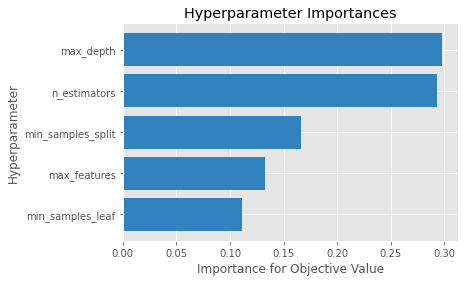

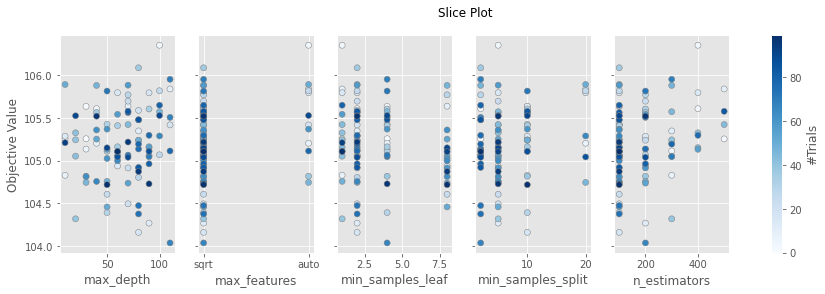

In [ ]:
print("Melhor conjunto de parâmetros:")
for key, value in rf_study.best_params.items():
    print(f"\t{key}: {value}")

print(f"Score: {rf_study.best_value}")

lgb_iterated_results.to_csv("hyperparameters/lgb_iterated.csv", index=False)
plot_param_importances(rf_study)
plot_slice(rf_study)

## Random forests: Avaliando o modelo ótimo na base de teste

In [16]:
# Parâmetros para configurar o formato dos dados para alimentar o modelo
data_params = {
    "steps_back": 5,
    "steps_forward": 15,

    "steps_back_spacing": 1,
    "steps_forward_spacing": 1,

    "add_downstream_data": True,
    "add_upstream_data": True
}

# Parâmetros para configurar o modelo
model_params = {
    "n_jobs": -1,
    "n_estimators": 200,
    "max_features": "sqrt",
    "max_depth": 110,
    "min_samples_split": 2,
    "min_samples_leaf": 4 
}

clean_data = get_clean_data(target_data, down_data, up_data, **data_params)

test_start, test_end = test_splits[-1]
# Separa dados de treino e teste      
X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

# Modelo Random Forests (suporta nativamente multiplas variáveis de saída)
rf_model = RandomForestRegressor()

# Treina o modelo
start = timer()
rf_model.fit(X_train, y_train)
end = timer()
train_time += end - start

# Realiza a predição
start = timer()
pred_rf = rf_model.predict(X_test)[:,-1]
end = timer()
pred_time += end - start

# Calcula acuracias para a iteção atual
mse = mean_squared_error(y_test.iloc[:,-1], pred_rf)
mae = mean_absolute_error(y_test.iloc[:,-1], pred_rf)
mape = mean_absolute_percentage_error(y_test.iloc[:,-1], pred_rf)

result_row = {
    "modelo": "Random Forests",
    "train_time [s]": train_time,
    "prediction_time [s]": pred_time,
    "MAPE": mape,
    "MAE": mae,
    "MSE": mse
}
results.append(result_row)

### Calculando resultados da média histórica

In [17]:
test_start, test_end = test_splits[-1]
# Separa dados de treino e teste      
X_train, X_test, y_train, y_test = timeseries_train_test_split(clean_data, test_start, test_end)

# Treina o modelo
start = timer()
y_train["min_sem"] = y_train.index.minute + y_train.index.hour * 60 + y_train.index.weekday * 60 * 24
media_hist = y_train.groupby(by="min_sem").mean()["V_t+15"]
end = timer()
train_time = end - start

# Realiza a predição
start = timer()
y_test["min_sem"] = y_test.index.minute + y_test.index.hour * 60 + y_test.index.weekday * 60 * 24
pred_media = media_hist[y_test["min_sem"]]
end = timer()
pred_time = end - start

# Calcula acuracias para a iteção atual
mse = mean_squared_error(y_test["V_t+15"], pred_media)
mae = mean_absolute_error(y_test["V_t+15"], pred_media)
mape = mean_absolute_percentage_error(y_test["V_t+15"], pred_media)

result_row = {
    "modelo": "Média histórica",
    "train_time [s]": train_time,
    "prediction_time [s]": pred_time,
    "MAPE": mape,
    "MAE": mae,
    "MSE": mse
}
results.append(result_row)
results_df = pd.DataFrame(results)


In [18]:
results_df

,modelo,train_time [s],prediction_time [s],MAPE,MAE,MSE
0,LightGBM direto,1.016354,0.022786,0.065963,6.225614,118.041307
1,LightGBM iterado,7.011297,0.206000,0.066170,6.359408,123.611239
2,Random Forests,81.334730,0.314321,0.067598,6.492944,120.863102
3,Média histórica,0.013629,0.002907,0.074280,7.178319,143.994830


## Importância das variáveis
Os modelos xgboost multioutput treinados não permitem a análise da importância de cada uma das variáveis. Por conta foi treinando um modelo que prevê apenas $ vel_{t+n} $, sendo $ n $ o número de passos para frente na previsão. Como o xgboost suporta a exibição da importância das variáveis para um modelo com apenas um output, o novo modelo treinado foi utilizado para tal.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

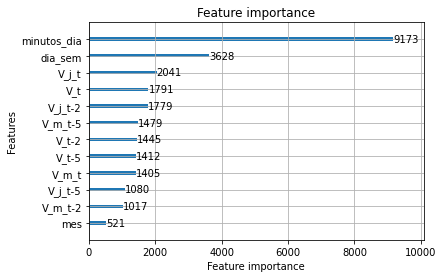

In [ ]:
lgb.plot_importance(lgb_model_direct)

## Comparações dos resultados
Com os resultados do primeiro gráfico é possível ver as previsões mais destoantes entre os modelos se encontra no dia 30 de Março (Sábado).
Para esse dia é possível ver que o modelo `xgb iterated` realização previsões com maior precisão.


In [23]:
steps_forward = data_params["steps_forward"]
cols = [f"lgb_direto_V_t+{steps_forward}", f"lgb_iterado_V_t+{steps_forward}", f"rf_V_t+{steps_forward}", f"media_hist_V_t+{steps_forward}", f"V_t+{steps_forward}"]

# Adiciona as predições na tabela test_data
predictions = pd.DataFrame()
predictions[cols[0]] = pred_lgb_direct
predictions[cols[1]] = pred_lgb_iterated[:, -1]
predictions[cols[2]] = pred_rf[:, -1]
predictions[cols[3]] = pred_media
predictions[cols[4]] = y_test[cols[4]]

# # test_data[y[0]] = xgb_model_direct.predict(X_test)
# # test_data[y[1]] = xgb_model_iterated.predict(X_test)[:,-1]
# test_data[y[2]] = lgb_model_direct.predict(X_test)
# test_data[y[3]] = lgb_model_iterated.predict(X_test)[:,-1]
# # test_data[y[3]] = rf_model.predict(X_test)[:,-1]

# # Altera o index to test_data para a data correspondente ao inves de um número inteiro para mostrar as datas na plottagem
# test_data.index = pd.to_datetime(test_data.index)

# # Plotta o gráfico com todas as predições
# # test_data[(test_data.index > split_date)].plot(style=".", y=y, alpha=0.3, title=f"Previsões a partir do dia {split_date}")
# # test_data[(test_data.index > split_date)].plot(style=".", y=[y[-1], y[0]], title=f"Previsões a partir do dia {split_date}")
# # test_data[(test_data.index > split_date)].plot(style=".", y=[y[-1], y[1]], title=f"Previsões a partir do dia {split_date}")
# test_data[(test_data.index > split_date)].plot(style=".", y=[y[-1], y[2]], title=f"Previsões a partir do dia {split_date}")
# # test_data[(test_data.index > split_date)].plot(style=".", y=[y[-1], y[3]], title=f"Previsões a partir do dia {split_date}")

# # Plotta os gráficos 
# start_date = "2018-03-30"
# end_date = start_date[:-2] + str(int(start_date[-2:]) + 1)
# # test_data[(test_data.index > start_date) & (test_data.index < end_date)].plot.line(y=[y[-1], y[0]], title=f"Previsão no dia {start_date} (xgb direct)")
# # test_data[(test_data.index > start_date) & (test_data.index < end_date)].plot.line(y=[y[-1], y[1]], title=f"Previsão no dia {start_date} (xgb iterated)")
# test_data[(test_data.index > start_date) & (test_data.index < end_date)].plot.line(y=[y[-1], y[2]], title=f"Previsão no dia {start_date} (lgb direct)")
# test_data[(test_data.index > start_date) & (test_data.index < end_date)].plot.line(y=[y[-1], y[3]], title=f"Previsão no dia {start_date} (lgb iterated)")
predictions

NameError: name 'predictions' is not defined

# Possíveis melhorias
- Usar forma de validação mais adequada (https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
- Considerar dados de radares a jusante e a montante
- Usar grid search para encontrar parâmetros melhores para os modelos
- Considerar o estado climático nas predições
- Encontrar uma forma de usar o xgboost multivariated (modelo que leva em consideração a correlação entre as variáveis de saída)
- Testar modelos de redes neurais